# Hidden in Plain Sight

In [1]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import psutil
import gzip
import statsmodels.api as sm
from scipy import stats
import numpy as np

### Checking out the Princeton data

In [2]:
conn = sqlite3.connect('/app/Data/release_db.sqlite')
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Tables in the database:")
for table in tables:
    print(table[0])
conn.close()


Tables in the database:
sites
sqlite_sequence
alexa_ranks
policy_texts
policy_htmls
policy_reader_view_htmls
policy_snapshots


In [3]:
conn = sqlite3.connect('/app/Data/release_db.sqlite')
cursor = conn.cursor()

# Get row counts for each table
cursor.execute("SELECT COUNT(*) FROM policy_texts")
policy_texts_count = cursor.fetchone()[0]

cursor.execute("SELECT COUNT(*) FROM sites")
sites_count = cursor.fetchone()[0]

cursor.execute("SELECT COUNT(*) FROM policy_snapshots")
snapshots_count = cursor.fetchone()[0]

conn.close()

print(f"policy_texts rows: {policy_texts_count}")
print(f"sites rows: {sites_count}")
print(f"policy_snapshots rows: {snapshots_count}")

policy_texts rows: 333986
sites rows: 130620
policy_snapshots rows: 1071487


In [4]:
def load_readability_data(chunksize=50000):
    conn = sqlite3.connect('/app/Data/release_db.sqlite')
    
    query = """
    SELECT 
        s.domain,
        s.categories,
        pt.flesch_kincaid,
        pt.smog,
        pt.flesch_ease,
        ps.year,
        ps.phase
    FROM 
        sites s
    JOIN 
        policy_snapshots ps ON s.id = ps.site_id
    JOIN 
        policy_texts pt ON ps.policy_text_id = pt.id
    """
    
    chunks = []
    for chunk in pd.read_sql_query(query, conn, chunksize=chunksize):
        print(f"Loaded chunk of size: {len(chunk)}")
        chunks.append(chunk)
        
    conn.close()
    
    return pd.concat(chunks, ignore_index=True)

# Load the data
df = load_readability_data()

print(f"Total rows loaded: {len(df)}")

Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 21487
Total rows loaded: 1071487


In [5]:
df.head()

,domain,categories,flesch_kincaid,smog,flesch_ease,year,phase
0,docusign.com,business;informationtech,14.938384,18.351184,difficult,2003,B
1,docusign.com,business;informationtech,13.762202,18.171460,difficult,2004,B
2,docusign.com,business;informationtech,13.640407,18.062587,difficult,2006,B
3,docusign.com,business;informationtech,13.640407,18.062587,difficult,2006,A
4,docusign.com,business;informationtech,13.762202,18.171460,difficult,2004,A


So what I'm looking at above is a dataset containing many many websites, and readability scores for their piracy policy texts over the years.

In [6]:
print(df.describe())

       flesch_kincaid           smog          year
count    1.044684e+06  678307.000000  1.071487e+06
mean     1.293594e+01      15.169765  2.013036e+03
std      1.861677e+00       1.559115  4.233258e+00
min      2.913221e-01       5.461319  1.997000e+03
25%      1.175368e+01      14.167174  2.011000e+03
50%      1.289556e+01      15.157563  2.014000e+03
75%      1.409708e+01      16.156166  2.016000e+03
max      4.824111e+01      24.248240  2.019000e+03


In [7]:
print(df.isnull().sum())

domain                 0
categories             0
flesch_kincaid     26803
smog              393180
flesch_ease        26803
year                   0
phase                  0
dtype: int64


In [8]:
nan_rows = df[(df['flesch_kincaid'].isna()) | (df['smog'].isna())]
print(nan_rows)

                     domain                          categories  \
42           docu-track.com  business;education;informationtech   
44           docu-track.com  business;education;informationtech   
45           docu-track.com  business;education;informationtech   
46           docu-track.com  business;education;informationtech   
47           docu-track.com  business;education;informationtech   
...                     ...                                 ...   
1071472         911tabs.com                            business   
1071473         911tabs.com                            business   
1071476         91p16.space                              parked   
1071479  99centarticles.com                  business;education   
1071480  99centarticles.com                  business;education   

         flesch_kincaid  smog       flesch_ease  year phase  
42            15.398920   NaN         difficult  2010     A  
44            15.398920   NaN         difficult  2010     B  
45       

In [9]:
df = df.dropna(subset=['flesch_kincaid'])

I'm dropping rows where the flesch_kincaid score is NaN / unavailable because (1) I'm not sure why a score might not be available/calculated (2) it doesn't make sense to impute it

In [10]:
# Correlation between readability scores
correlation_matrix = df[['flesch_kincaid', 'smog']].corr()
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
                flesch_kincaid      smog
flesch_kincaid        1.000000  0.876276
smog                  0.876276  1.000000


In [11]:
# Average readability scores by year
yearly_averages = df.groupby('year')[['flesch_kincaid', 'smog', 'flesch_ease']].mean()
print("Yearly Averages:")
print(yearly_averages)


Yearly Averages:
      flesch_kincaid       smog
year                           
1997       13.112056  14.440260
1998       12.720505  14.385156
1999       12.358348  14.386897
2000       12.155811  14.340922
2001       12.306016  14.540814
2002       12.381935  14.662638
2003       12.403658  14.692982
2004       12.461684  14.771178
2005       12.529386  14.823040
2006       12.599056  14.895032
2007       12.710667  15.017304
2008       12.770552  15.084850
2009       12.853273  15.138784
2010       12.898256  15.172349
2011       12.873741  15.186714
2012       12.894060  15.158584
2013       12.932845  15.171375
2014       12.977552  15.194985
2015       13.013354  15.214721
2016       13.027146  15.225705
2017       13.098925  15.260321
2018       13.142320  15.297925
2019       13.167947  15.261569


/tmp/ipykernel_2381/2084141685.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  yearly_averages = df.groupby('year')[['flesch_kincaid', 'smog', 'flesch_ease']].mean()


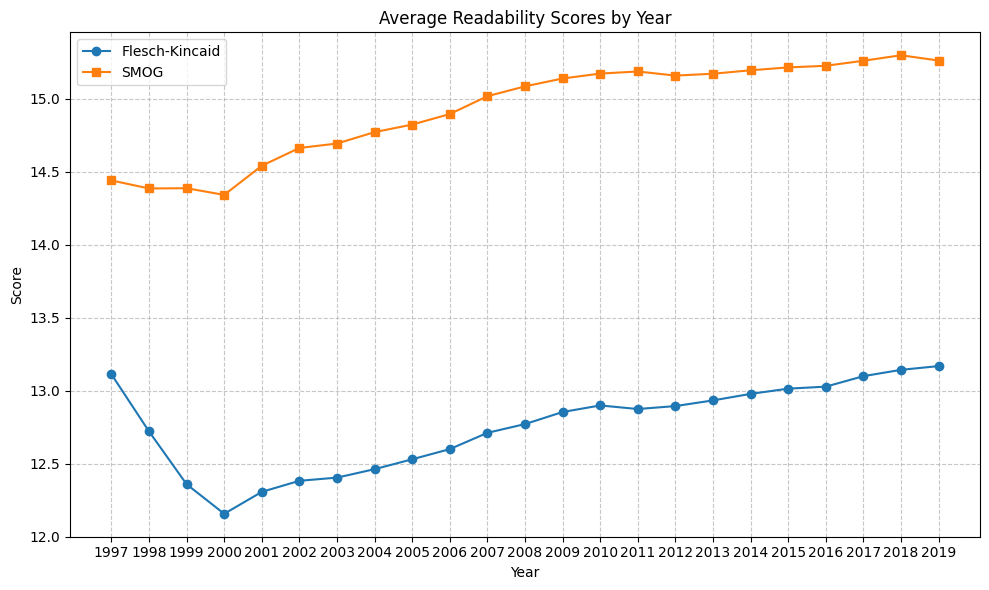

In [12]:
# Prepare the data
yearly_averages = df.groupby('year')[['flesch_kincaid', 'smog']].mean()

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(yearly_averages.index, yearly_averages['flesch_kincaid'], marker='o', label='Flesch-Kincaid')
plt.plot(yearly_averages.index, yearly_averages['smog'], marker='s', label='SMOG')

plt.title('Average Readability Scores by Year')
plt.xlabel('Year')
plt.ylabel('Score')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Ensure x-axis shows all years
plt.xticks(yearly_averages.index)

plt.tight_layout()
plt.show()

In [13]:
# Create yearly averages dataframe with year as a regular column
yearly_averages_reset = yearly_averages.reset_index()

# Run regression on yearly averages
def analyze_yearly_trend(score_type):
    # Prepare data
    X = sm.add_constant(yearly_averages_reset['year'])
    y = yearly_averages_reset[score_type]
    
    # Fit model
    model = sm.OLS(y, X).fit()
    
    print(f"\nRegression Results for {score_type} (Using Yearly Averages):")
    print(model.summary().tables[1])
    
    # Calculate correlation
    correlation = yearly_averages_reset[['year', score_type]].corr().iloc[0,1]
    print(f"Correlation coefficient between year and {score_type}: {correlation:.4f}")

# Run analysis for both metrics
analyze_yearly_trend('flesch_kincaid')
analyze_yearly_trend('smog')



Regression Results for flesch_kincaid (Using Yearly Averages):
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -53.0067     13.152     -4.030      0.001     -80.357     -25.657
year           0.0328      0.007      5.000      0.000       0.019       0.046
Correlation coefficient between year and flesch_kincaid: 0.7372

Regression Results for smog (Using Yearly Averages):
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -77.7768      6.776    -11.479      0.000     -91.868     -63.686
year           0.0462      0.003     13.682      0.000       0.039       0.053
Correlation coefficient between year and smog: 0.9482


1. Flesch-Kincaid Score:

    Strong positive correlation (r = 0.7372) between year and Flesch-Kincaid scores
    The coefficient (0.0328) indicates scores increase by 0.0328 units per year
    Highly significant (p < 0.001) relationship
    The model explains that starting from a baseline of -53.0067 in year 0, readability scores have been increasing yearly

2. SMOG Score Analysis:

    Very strong positive correlation (r = 0.9482) between year and SMOG scores
    The coefficient (0.0462) shows scores increase by 0.0462 units per year
    Extremely significant (p < 0.001) relationship
    Similar to Flesch-Kincaid, starts from -77.7768 and increases yearly

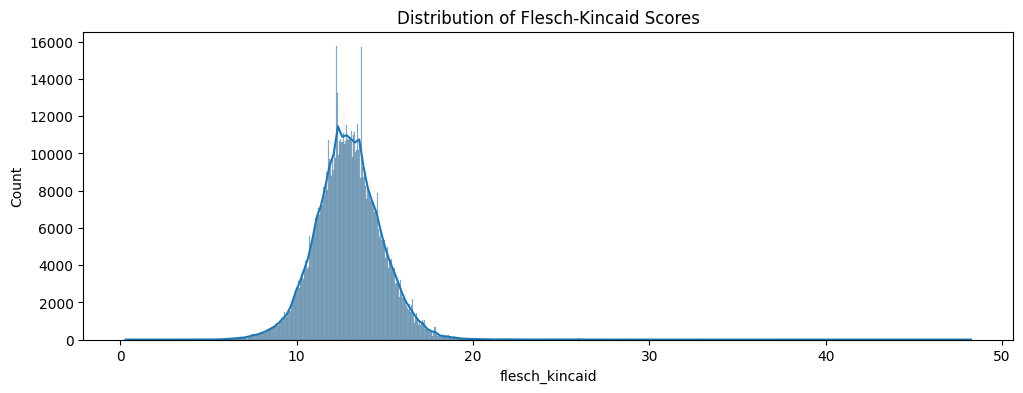

In [14]:
plt.figure(figsize=(12, 4))
sns.histplot(df['flesch_kincaid'], kde=True)
plt.title('Distribution of Flesch-Kincaid Scores')
plt.show()

### Checking out the Trackers data

In [15]:
# Load the index file. This one has info on the website's domain name + a unique identifier for each domain
df_index = pd.read_csv('/app/Data/pld-index.tsv.gz', sep='\t', names=['domain', 'domain_id'], compression='gzip')

# Load the tracking file. This one has the unique ID and the ID of a third-party tracker assoc. w that website
df_track = pd.read_csv('/app/Data/tracking-graph.tsv.gz', sep='\t', names=['domain_id', 'tracking_domain_id'], compression='gzip')
# Something to note here that I initially found a bit confusing is that the third-party data sharing info is not a 
# single number, but rather a relationship b/w websites and trackers. So each row in df_track is a connection b/w
# a website and a third-party tracker

print("Index file shape:", df_index.shape)
print("Tracking file shape:", df_track.shape)

Index file shape: (46269087, 2)
Tracking file shape: (36982655, 2)


In [16]:
# Define dtypes for more efficient memory usage
dtypes = {
    'domain_id': 'int32',  # Assuming domain_id is numeric
    'tracking_domain_id': 'int32',
    'domain': 'category'  # Since domain names are likely to have repeats
}

# Load index file with optimized dtypes
df_index = pd.read_csv('/app/Data/pld-index.tsv.gz', 
                      sep='\t', 
                      names=['domain', 'domain_id'],
                      dtype=dtypes,
                      compression='gzip')

# Process tracking data in chunks and count trackers# Define smaller chunk size
chunk_size = 100000  # Reduced from 1 million to 100k rows

# Define dtypes for more efficient memory usage
dtypes = {
    'domain_id': 'int32',
    'tracking_domain_id': 'int32',
    'domain': 'category'
}

# Process in smaller chunks with intermediate saving
tracker_counts = None
chunk_counter = 0

for chunk in pd.read_csv('/app/Data/tracking-graph.tsv.gz',
                        sep='\t',
                        names=['domain_id', 'tracking_domain_id'],
                        dtype=dtypes,
                        compression='gzip',
                        chunksize=chunk_size):
    # Count trackers for this chunk
    chunk_counts = chunk.groupby('domain_id').size().reset_index(name='count')
    
    # Update running counts
    if tracker_counts is None:
        tracker_counts = chunk_counts
    else:
        # Add new counts to existing ones
        tracker_counts = pd.concat([tracker_counts, chunk_counts])
        tracker_counts = tracker_counts.groupby('domain_id')['count'].sum().reset_index()
    
    # Clear memory
    del chunk
    del chunk_counts
    
    chunk_counter += 1
    print(f"Processed chunk {chunk_counter}")
    
    # Optional: Save intermediate results periodically
    if chunk_counter % 10 == 0:
        print(f"Saving intermediate results after {chunk_counter} chunks")
        tracker_counts.to_csv(f'intermediate_counts_{chunk_counter}.csv', index=False)

chunk_size = 1000000  # 1 million rows per chunk
tracker_counts = pd.DataFrame()

# Process tracking file in chunks to count trackers
for chunk in pd.read_csv('/app/Data/tracking-graph.tsv.gz',
                        sep='\t',
                        names=['domain_id', 'tracking_domain_id'],
                        dtype=dtypes,
                        compression='gzip',
                        chunksize=chunk_size):
    # Count trackers for this chunk
    chunk_counts = chunk.groupby('domain_id').size().reset_index(name='count')
    
    # Accumulate counts
    if tracker_counts.empty:
        tracker_counts = chunk_counts
    else:
        tracker_counts = pd.concat([tracker_counts, chunk_counts])
        # Sum up counts for same domain_ids
        tracker_counts = tracker_counts.groupby('domain_id')['count'].sum().reset_index()
    
    print(f"Processed chunk of tracking data")

# Final merge with index file
df_tracking_merged = pd.merge(tracker_counts, df_index, on='domain_id', how='left')


Processed chunk 1
Processed chunk 2
Processed chunk 3
Processed chunk 4
Processed chunk 5
Processed chunk 6
Processed chunk 7
Processed chunk 8
Processed chunk 9
Processed chunk 10
Saving intermediate results after 10 chunks
Processed chunk 11
Processed chunk 12
Processed chunk 13
Processed chunk 14
Processed chunk 15
Processed chunk 16
Processed chunk 17
Processed chunk 18
Processed chunk 19
Processed chunk 20
Saving intermediate results after 20 chunks
Processed chunk 21
Processed chunk 22
Processed chunk 23
Processed chunk 24
Processed chunk 25
Processed chunk 26
Processed chunk 27
Processed chunk 28
Processed chunk 29
Processed chunk 30
Saving intermediate results after 30 chunks
Processed chunk 31
Processed chunk 32
Processed chunk 33
Processed chunk 34
Processed chunk 35
Processed chunk 36
Processed chunk 37
Processed chunk 38
Processed chunk 39
Processed chunk 40
Saving intermediate results after 40 chunks
Processed chunk 41
Processed chunk 42
Processed chunk 43
Processed chunk 

KeyboardInterrupt: 

In [1]:
# Define dtypes for more efficient memory usage
dtypes = {
    'domain_id': 'int32',  # Assuming domain_id is numeric
    'tracking_domain_id': 'int32',
    'domain': 'category'  # Since domain names are likely to have repeats
}

# Load index file with optimized dtypes
df_index = pd.read_csv('/app/Data/pld-index.tsv.gz', 
                      sep='\t', 
                      names=['domain', 'domain_id'],
                      dtype=dtypes,
                      compression='gzip')

# Process tracking data in chunks and count trackers
chunk_size = 1000000  # 1 million rows per chunk
tracker_counts = pd.DataFrame()

# Process tracking file in chunks to count trackers
for chunk in pd.read_csv('/app/Data/tracking-graph.tsv.gz',
                        sep='\t',
                        names=['domain_id', 'tracking_domain_id'],
                        dtype=dtypes,
                        compression='gzip',
                        chunksize=chunk_size):
    # Count trackers for this chunk
    chunk_counts = chunk.groupby('domain_id').size().reset_index(name='count')
    
    # Accumulate counts
    if tracker_counts.empty:
        tracker_counts = chunk_counts
    else:
        tracker_counts = pd.concat([tracker_counts, chunk_counts])
        # Sum up counts for same domain_ids
        tracker_counts = tracker_counts.groupby('domain_id')['count'].sum().reset_index()
    
    print(f"Processed chunk of tracking data")

# Final merge with index file
df_tracking_merged = pd.merge(tracker_counts, df_index, on='domain_id', how='left')


NameError: name 'pd' is not defined

In [ ]:
df_tracking_merged = pd.merge(df_track, df_index, on='domain_id', how='left')
print("Merged tracking data shape:", df_tracking_merged.shape)
print(df_tracking_merged.head())

In [ ]:
readability_domains = set(df['domain'])
tracking_domains = set(df_tracking_merged['domain'])

common_domains = readability_domains.intersection(tracking_domains)

print(f"Number of domains in readability data: {len(readability_domains)}")
print(f"Number of domains in tracking data: {len(tracking_domains)}")
print(f"Number of common domains: {len(common_domains)}")


Number of domains in readability data: 128610
Number of domains in tracking data: 18782899
Number of common domains: 70460


### Merging Tracking & Readability Data (by domain and year 2012)

In [ ]:
# Filter readability data for 2012
df_2012 = df[df['year'] == 2012]

# Count the number of trackers for each domain
tracker_counts = df_tracking_merged.groupby('domain').size().reset_index(name='tracker_count')

# Merge 2012 readability data with tracking data
df_combined = pd.merge(df_2012, tracker_counts, on='domain', how='left')

# Fill NaN values in tracker_count with 0 (for websites with no tracking data)
df_combined['tracker_count'] = df_combined['tracker_count'].fillna(0)

print("Combined data shape:", df_combined.shape)
print(df_combined.head())


Combined data shape: (83511, 8)
           domain                          categories  flesch_kincaid  \
0    docusign.com            business;informationtech       13.595953   
1    docusign.com            business;informationtech       13.595953   
2  docu-track.com  business;education;informationtech       15.398920   
3  docu-track.com  business;education;informationtech       15.398920   
4  dodgeforum.com                            vehicles       12.122879   

        smog flesch_ease  year phase  tracker_count  
0  17.842426   difficult  2012     B           12.0  
1  17.842426   difficult  2012     A           12.0  
2        NaN   difficult  2012     A            0.0  
3        NaN   difficult  2012     B            0.0  
4  13.506819   difficult  2012     A           11.0  


In [ ]:
zero_tracker_count = (df_combined['tracker_count'] == 0).sum()
total_rows = len(df_combined)
percentage = (zero_tracker_count / total_rows) * 100

print(f"Number of rows with tracker_count = 0: {zero_tracker_count}")
print(f"Percentage of rows with tracker_count = 0: {percentage:.2f}%")

Number of rows with tracker_count = 0: 13311
Percentage of rows with tracker_count = 0: 15.94%


### Checking Correlations

#### Before removing websites with 0 trackers

In [ ]:
# Correlation between readability scores and tracker count
correlation = df_combined[['flesch_kincaid', 'smog', 'flesch_ease', 'tracker_count']].corr()
print("Correlation matrix:")
print(correlation)

Correlation matrix:
                flesch_kincaid      smog  tracker_count
flesch_kincaid        1.000000  0.871137       0.021087
smog                  0.871137  1.000000       0.013121
tracker_count         0.021087  0.013121       1.000000


/tmp/ipykernel_162360/104042176.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = df_combined[['flesch_kincaid', 'smog', 'flesch_ease', 'tracker_count']].corr()


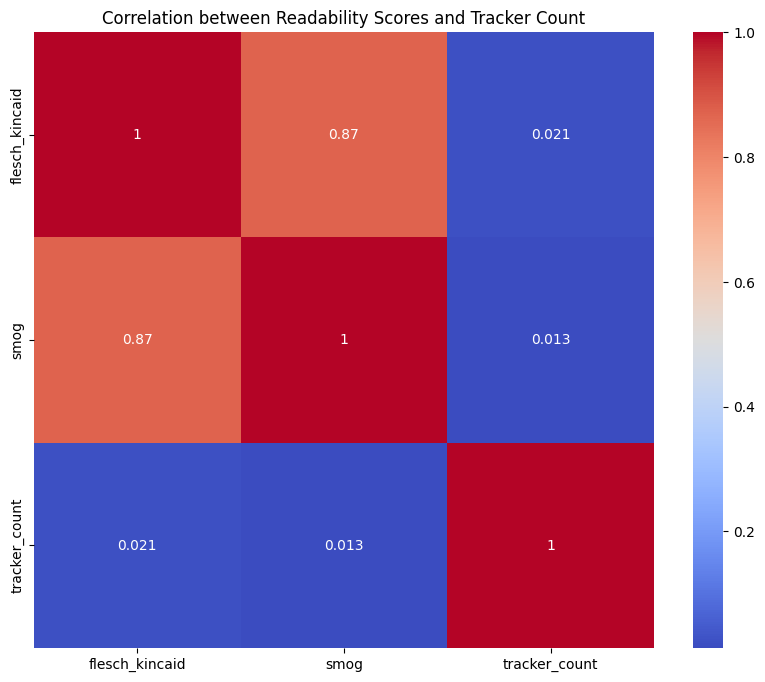

In [ ]:
# Visualize the correlation
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation between Readability Scores and Tracker Count')
plt.show()

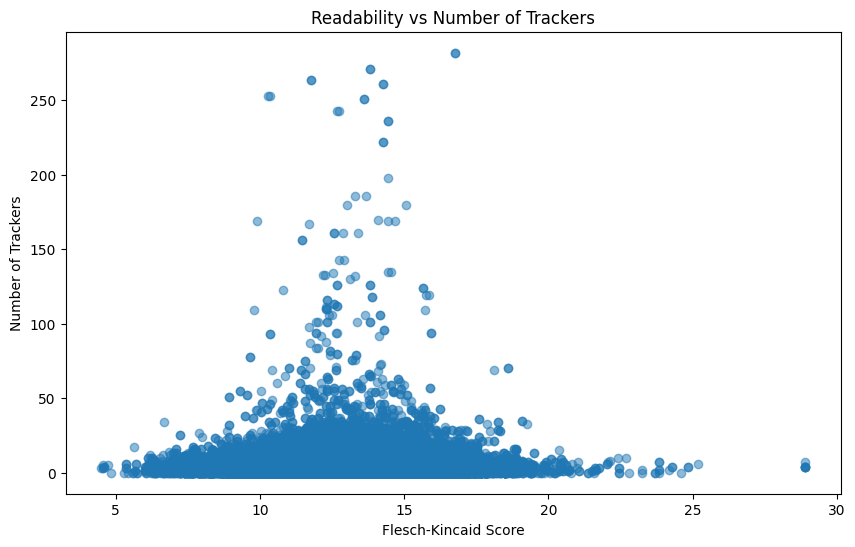

In [ ]:
# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df_combined['flesch_kincaid'], df_combined['tracker_count'], alpha=0.5)
plt.xlabel('Flesch-Kincaid Score')
plt.ylabel('Number of Trackers')
plt.title('Readability vs Number of Trackers')
plt.show()

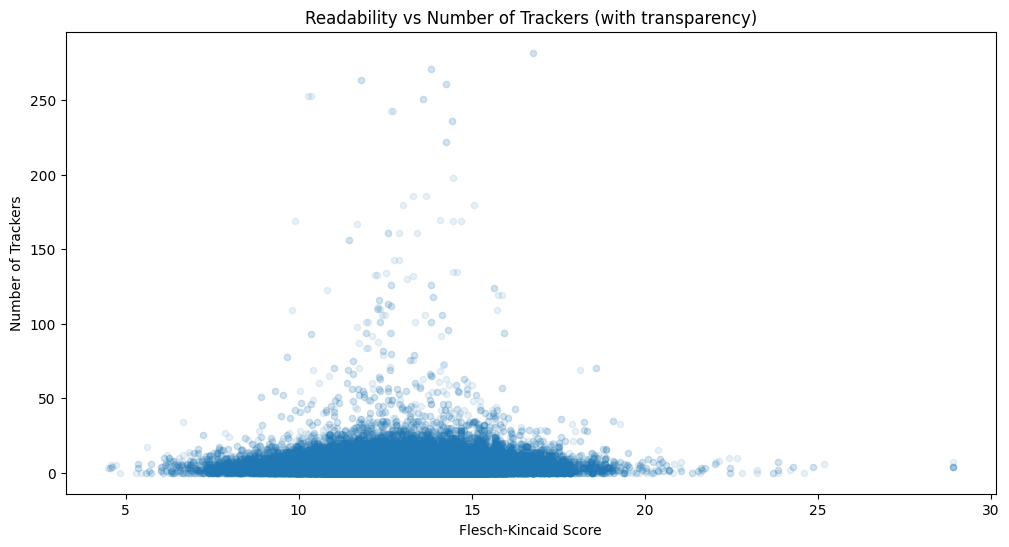

In [ ]:
# Option 1: Add transparency to see density
plt.figure(figsize=(12, 6))
plt.scatter(df_combined['flesch_kincaid'], df_combined['tracker_count'],
           alpha=0.1, # Make points transparent
           s=20)     # Adjust point size
plt.xlabel('Flesch-Kincaid Score')
plt.ylabel('Number of Trackers')
plt.title('Readability vs Number of Trackers (with transparency)')
plt.show()


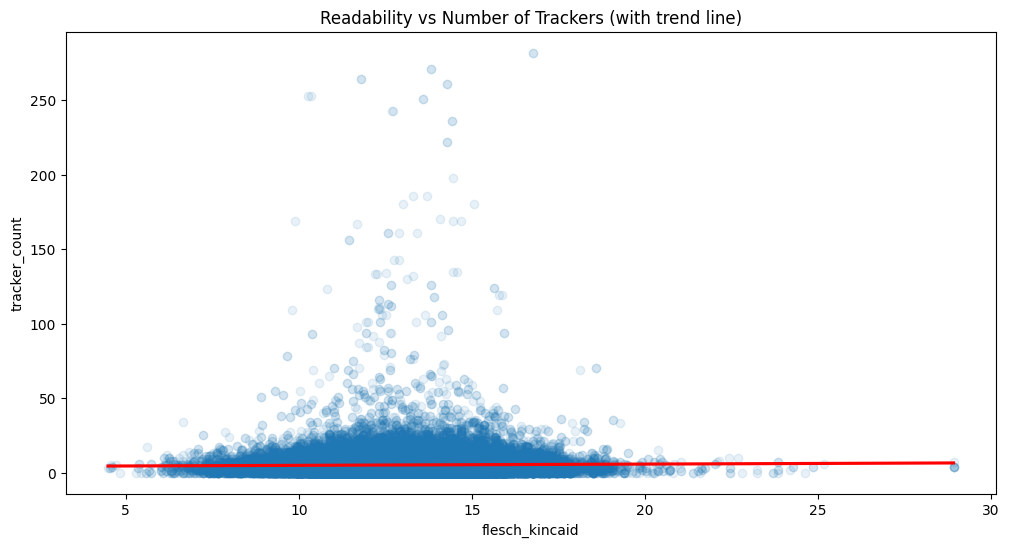

In [ ]:
# Option 3: Add a trend line
plt.figure(figsize=(12, 6))
sns.regplot(data=df_combined, x='flesch_kincaid', y='tracker_count',
            scatter_kws={'alpha':0.1}, 
            line_kws={'color': 'red'})
plt.title('Readability vs Number of Trackers (with trend line)')
plt.show()

#### Accounting for websites with 0 trackers and removing them

In [ ]:
# Count how many websites have 0 trackers
zero_trackers = len(df_combined[df_combined['tracker_count'] == 0])
total_websites = len(df_combined)

print(f"Websites with 0 trackers: {zero_trackers} out of {total_websites}")
print(f"Percentage: {(zero_trackers/total_websites)*100:.2f}%")

# Look at the distribution of tracker counts
print("\nTracker count distribution:")
print(df_combined['tracker_count'].describe())

# Check how many were originally NaN before we filled with 0
original_nans = df_combined['tracker_count'].isna().sum()
print(f"\nOriginal NaN values: {original_nans}")

Websites with 0 trackers: 13311 out of 83511
Percentage: 15.94%

Tracker count distribution:
count    83511.000000
mean         5.104417
std          7.503920
min          0.000000
25%          1.000000
50%          4.000000
75%          7.000000
max        282.000000
Name: tracker_count, dtype: float64

Original NaN values: 0


In [ ]:
# Create a new dataframe without the 0 tracker websites
df_filtered = df_combined[df_combined['tracker_count'] > 0]

print(f"Original dataset size: {len(df_combined)}")
print(f"Dataset size after removing 0 trackers: {len(df_filtered)}")
print(f"Removed {len(df_combined) - len(df_filtered)} entries")

# Look at the new distribution
print("\nNew tracker count distribution:")
print(df_filtered['tracker_count'].describe())

Original dataset size: 83511
Dataset size after removing 0 trackers: 70200
Removed 13311 entries

New tracker count distribution:
count    70200.000000
mean         6.072293
std          7.817204
min          1.000000
25%          2.000000
50%          5.000000
75%          8.000000
max        282.000000
Name: tracker_count, dtype: float64


In [ ]:
# Filter websites with more than 100 trackers
high_tracker_sites = df_filtered[df_filtered['tracker_count'] > 100]

# Print the number of websites with more than 100 trackers
print(f"Number of websites with more than 100 trackers: {len(high_tracker_sites)}")

# Print the rows of these websites
print("\nWebsites with more than 100 trackers:")
print(high_tracker_sites)

Number of websites with more than 100 trackers: 78

Websites with more than 100 trackers:
                domain                categories  flesch_kincaid       smog  \
4795         jigsy.com                  business       10.804570        NaN   
5643     onlinehome.us                  business       13.120425  16.197853   
8770   squarespace.com                  business       13.690025  16.363286   
8771   squarespace.com                  business       13.302502  16.114345   
9241        weebly.com                  business       12.730050  14.975303   
...                ...                       ...             ...        ...   
81011      appspot.com                  business       13.305238  13.611120   
82807       0catch.com  business;informationtech       13.832591        NaN   
82808       0catch.com  business;informationtech       13.832591        NaN   
83358       50webs.com  business;informationtech        9.891117  12.340627   
83460           8k.com                  b

In [ ]:
df_filtered.head()

,domain,categories,flesch_kincaid,smog,flesch_ease,year,phase,tracker_count
0,docusign.com,business;informationtech,13.595953,17.842426,difficult,2012,B,12.0
1,docusign.com,business;informationtech,13.595953,17.842426,difficult,2012,A,12.0
4,dodgeforum.com,vehicles,12.122879,13.506819,difficult,2012,A,11.0
5,dodgeforum.com,vehicles,12.703179,NaN,difficult,2012,B,11.0
6,dodlive.mil,business;education,15.984423,NaN,very_confusing,2012,B,13.0


In [ ]:
df_filtered.columns

Index(['domain', 'categories', 'flesch_kincaid', 'smog', 'flesch_ease', 'year',
       'phase', 'tracker_count'],
      dtype='object')

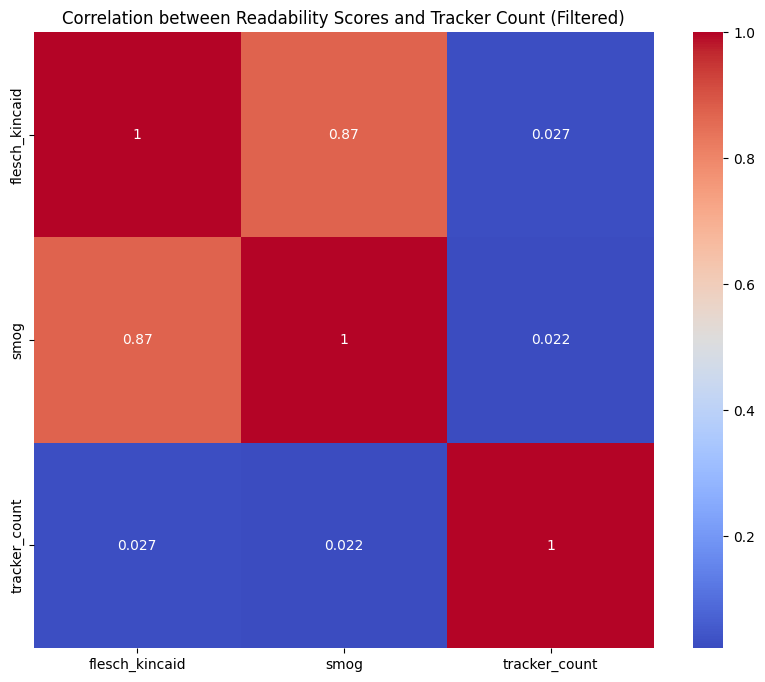

In [ ]:
# New correlation matrix
correlation_filtered = df_filtered[['flesch_kincaid', 'smog', 'tracker_count']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_filtered, annot=True, cmap='coolwarm')
plt.title('Correlation between Readability Scores and Tracker Count (Filtered)')
plt.show()

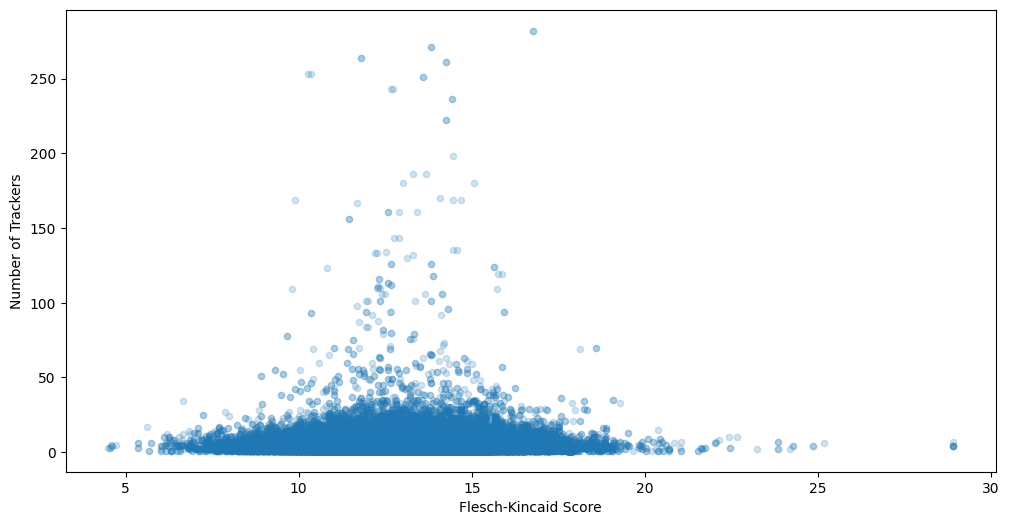

In [ ]:
# New scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(df_filtered['flesch_kincaid'], df_filtered['tracker_count'], alpha = 0.2, s=20)
plt.xlabel('Flesch-Kincaid Score')
plt.ylabel('Number of Trackers')
plt.title('')
plt.show()

In [ ]:
def run_regression(dep_var, ind_var):
    # Remove any rows with non-finite values
    df_clean = df_filtered[[dep_var, ind_var]].dropna()
    
    # Check if we have enough data points
    if len(df_clean) < 2:
        return f"Not enough valid data points for regression between {dep_var} and {ind_var}"
    
    # Check for zero variance
    if df_clean[dep_var].var() == 0 or df_clean[ind_var].var() == 0:
        return f"Zero variance in {dep_var} or {ind_var}, regression not possible"
    
    X = sm.add_constant(df_clean[ind_var])
    y = df_clean[dep_var]
    
    try:
        model = sm.OLS(y, X).fit()
        return model.summary()
    except Exception as e:
        return f"Error in regression for {dep_var} and {ind_var}: {str(e)}"

# Running regression for each variable relationship
results_flesch_kincaid = run_regression('tracker_count', 'flesch_kincaid')
results_smog = run_regression('tracker_count', 'smog')

# Print the results
print("Regression results for Flesch-Kincaid and tracker count:")
print(results_flesch_kincaid)
print("\nRegression results for SMOG and tracker count:")
print(results_smog)

# We can't run regression for flesch_ease as it's a categorical variable

# Additional data exploration
print("\nDescriptive statistics:")
print(df_filtered[['flesch_kincaid', 'smog', 'tracker_count']].describe())

print("\nUnique values in each column:")
for col in ['flesch_kincaid', 'smog', 'tracker_count', 'flesch_ease']:
    print(f"{col}: {df_filtered[col].unique().tolist()}")

# Check for any remaining non-finite values
print("\nCount of non-finite values in each column:")
print(df_filtered.isnull().sum())


Regression results for Flesch-Kincaid and tracker count:
                            OLS Regression Results                            
Dep. Variable:          tracker_count   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     52.90
Date:                Fri, 06 Dec 2024   Prob (F-statistic):           3.54e-13
Time:                        11:48:39   Log-Likelihood:            -2.4394e+05
No. Observations:               70200   AIC:                         4.879e+05
Df Residuals:                   70198   BIC:                         4.879e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

In [ ]:
# Verify our filtering worked
print("Number of websites with 0 trackers:", len(df_filtered[df_filtered['tracker_count'] == 0]))

# Look at the minimum tracker count
print("\nMinimum tracker count:", df_filtered['tracker_count'].min())

# Look at distribution of low tracker counts (e.g., 0-5)
print("\nDistribution of low tracker counts:")
print(df_filtered['tracker_count'].value_counts().sort_index().head())


Number of websites with 0 trackers: 0

Minimum tracker count: 1.0

Distribution of low tracker counts:
1.0    9331
2.0    9152
3.0    8487
4.0    7758
5.0    6908
Name: tracker_count, dtype: int64


### Looking at specific categories only

In [ ]:
all_categories = df['categories'].str.split(';', expand=True).stack().unique()
print("All unique individual categories:")
print(all_categories)

All unique individual categories:
['business' 'informationtech' 'education' 'searchenginesandportals'
 'uncategorized' 'vehicles' 'shopping' 'foodandrecipes' '' 'parked'
 'entertainment' 'adult' 'sports' 'games' 'newsandmedia' 'travel'
 'jobrelated' 'economyandfinance' 'streamingmedia' 'realestate'
 'blogsandpersonal' 'contentserver' 'gambling' 'personals' 'advertising'
 'messageboardsandforums' 'weapons' 'health' 'religion' 'mediasharing'
 'drugs' 'proxyandfilteravoidance' 'illegalcontent' 'socialnetworking'
 'humor' 'alcoholandtobacco' 'chatandmessaging' 'translators' 'deceptive'
 'hacking' 'malicious' 'virtualreality']


In [ ]:
# Split the categories column
df_filtered['categories'] = df_filtered['categories'].fillna('')
categories = df_filtered['categories'].str.get_dummies(sep=';')

# Combine the original DataFrame with the new category columns
df_expanded = pd.concat([df_filtered, categories], axis=1)
df_expanded.head()

/tmp/ipykernel_162360/992260521.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['categories'] = df_filtered['categories'].fillna('')


,domain,categories,flesch_kincaid,smog,flesch_ease,year,phase,tracker_count,adult,advertising,...,shopping,socialnetworking,sports,streamingmedia,translators,travel,uncategorized,vehicles,virtualreality,weapons
0,docusign.com,business;informationtech,13.595953,17.842426,difficult,2012,B,12.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,docusign.com,business;informationtech,13.595953,17.842426,difficult,2012,A,12.0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,dodgeforum.com,vehicles,12.122879,13.506819,difficult,2012,A,11.0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,dodgeforum.com,vehicles,12.703179,NaN,difficult,2012,B,11.0,0,0,...,0,0,0,0,0,0,0,1,0,0
6,dodlive.mil,business;education,15.984423,NaN,very_confusing,2012,B,13.0,0,0,...,0,0,0,0,0,0,0,0,0,0


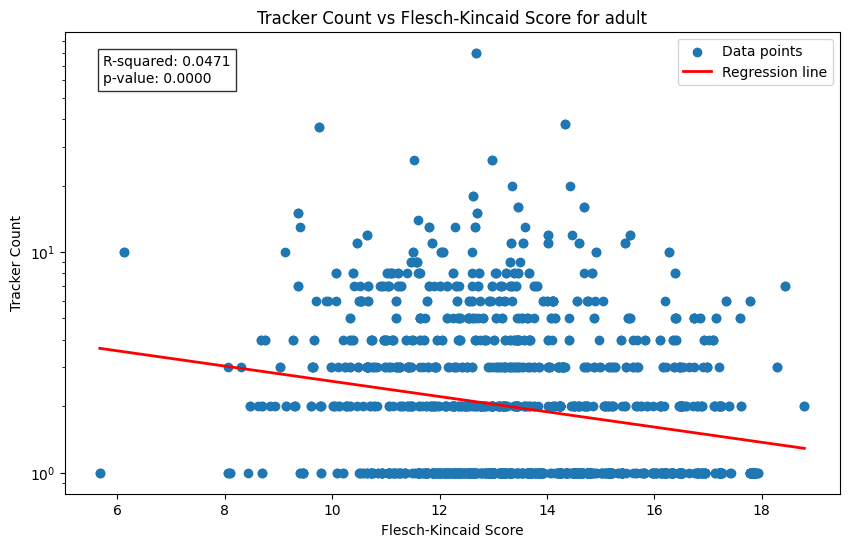


Regression Statistics for adult:
Slope: -0.0345
Intercept: 0.7595
R-squared: 0.0471
p-value: 0.0000


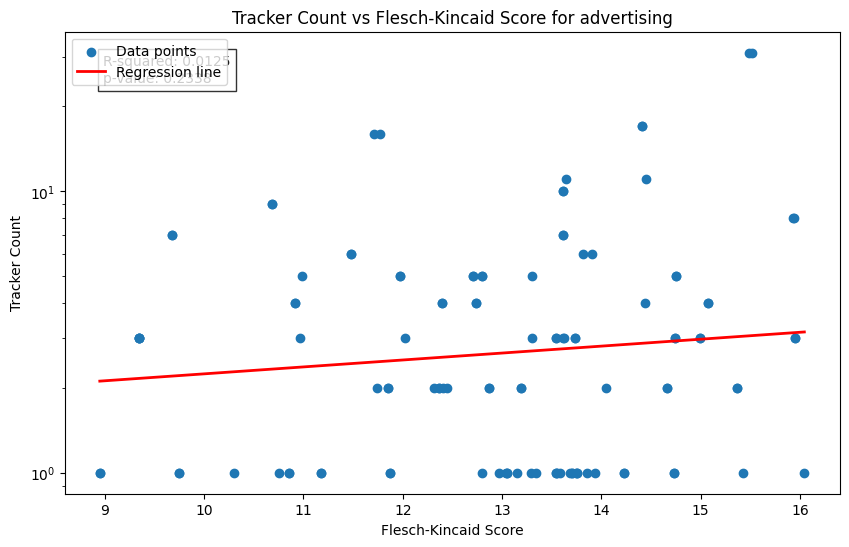


Regression Statistics for advertising:
Slope: 0.0246
Intercept: 0.1050
R-squared: 0.0125
p-value: 0.2338


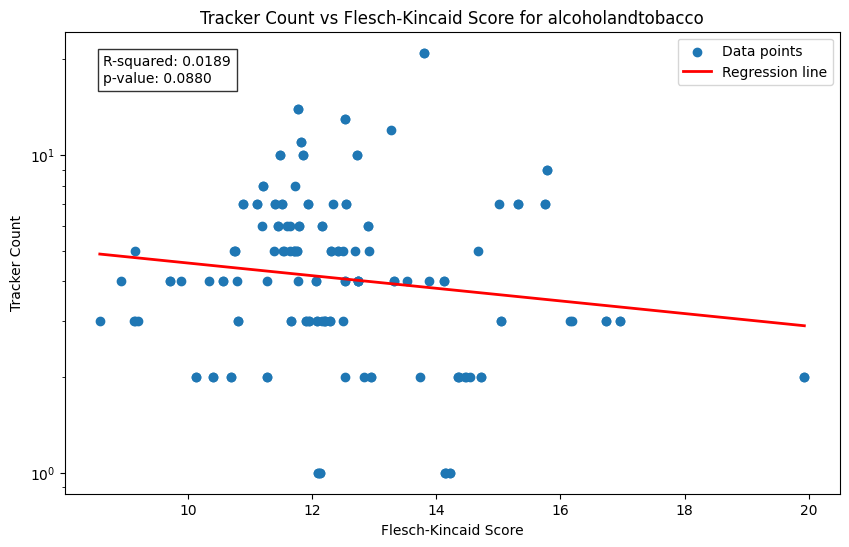


Regression Statistics for alcoholandtobacco:
Slope: -0.0199
Intercept: 0.8590
R-squared: 0.0189
p-value: 0.0880


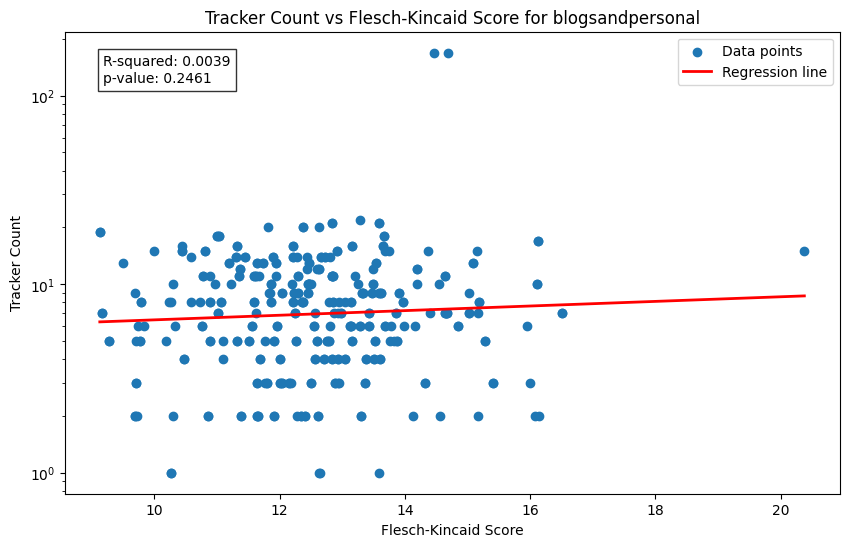


Regression Statistics for blogsandpersonal:
Slope: 0.0122
Intercept: 0.6884
R-squared: 0.0039
p-value: 0.2461


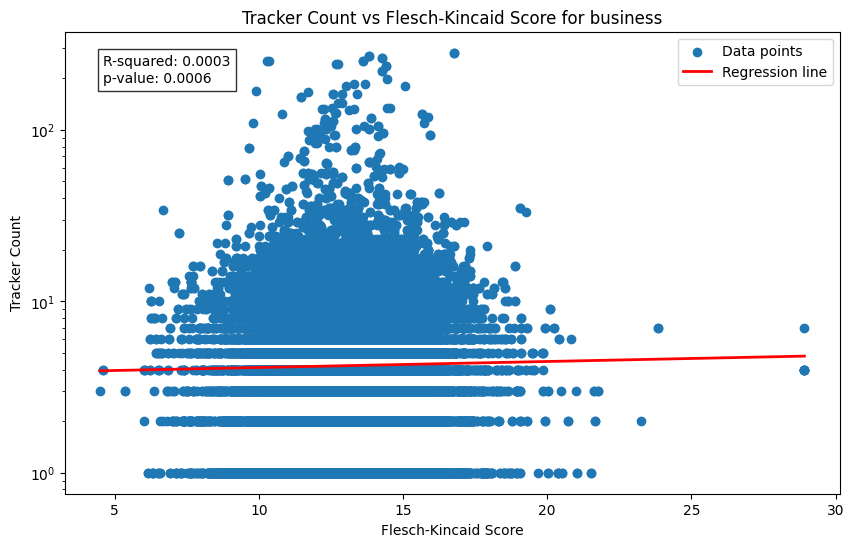


Regression Statistics for business:
Slope: 0.0035
Intercept: 0.5788
R-squared: 0.0003
p-value: 0.0006


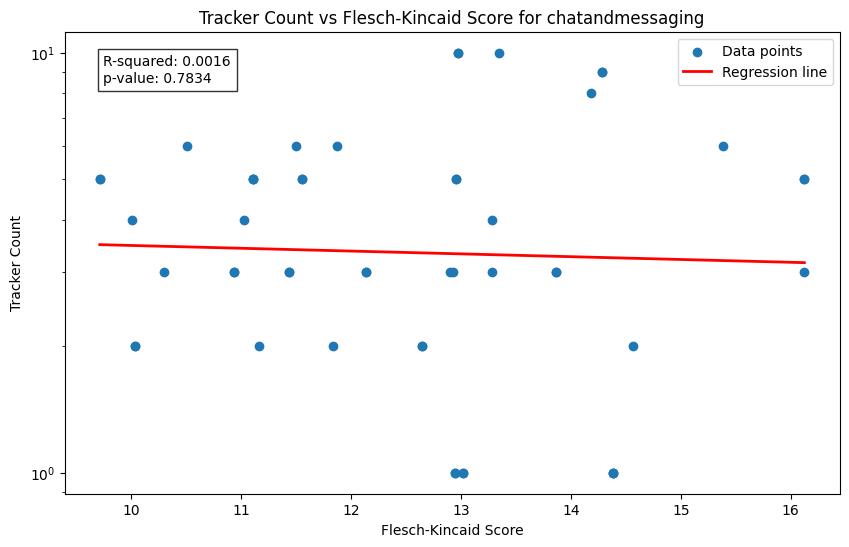


Regression Statistics for chatandmessaging:
Slope: -0.0067
Intercept: 0.6079
R-squared: 0.0016
p-value: 0.7834


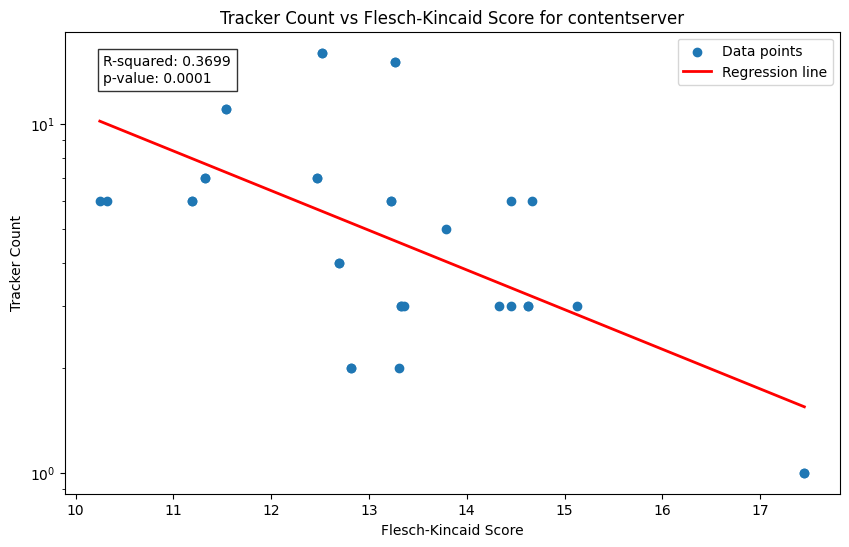


Regression Statistics for contentserver:
Slope: -0.1137
Intercept: 2.1729
R-squared: 0.3699
p-value: 0.0001


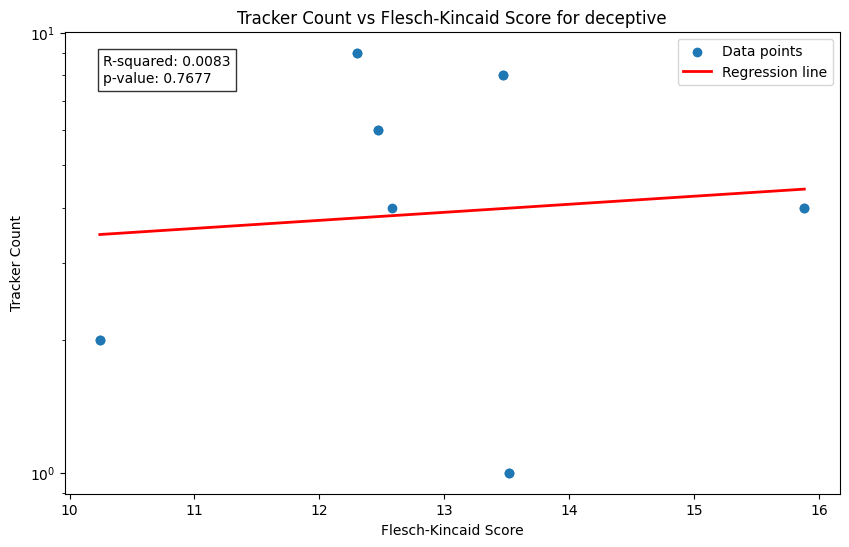


Regression Statistics for deceptive:
Slope: 0.0183
Intercept: 0.3538
R-squared: 0.0083
p-value: 0.7677


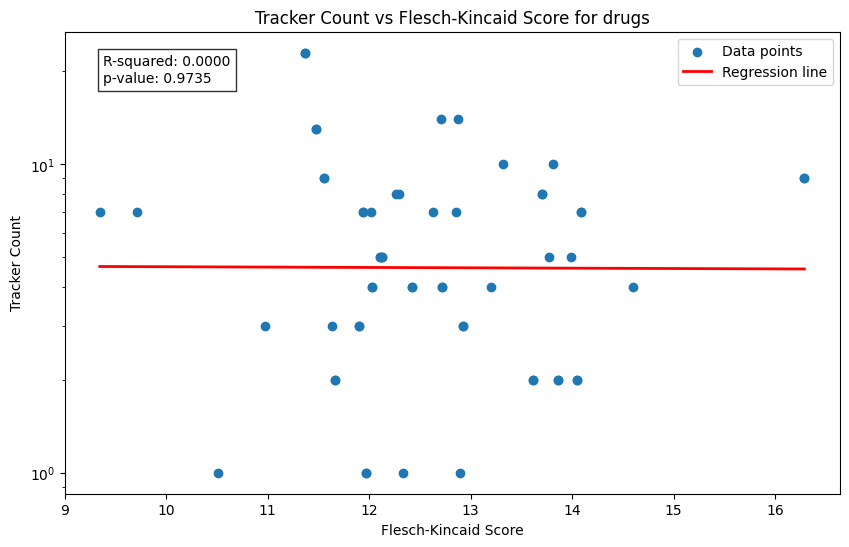


Regression Statistics for drugs:
Slope: -0.0012
Intercept: 0.6795
R-squared: 0.0000
p-value: 0.9735


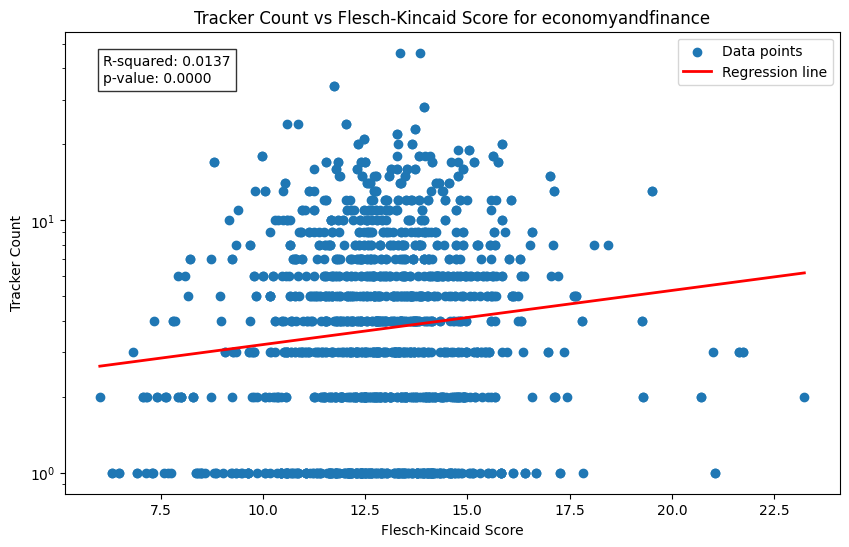


Regression Statistics for economyandfinance:
Slope: 0.0214
Intercept: 0.2928
R-squared: 0.0137
p-value: 0.0000


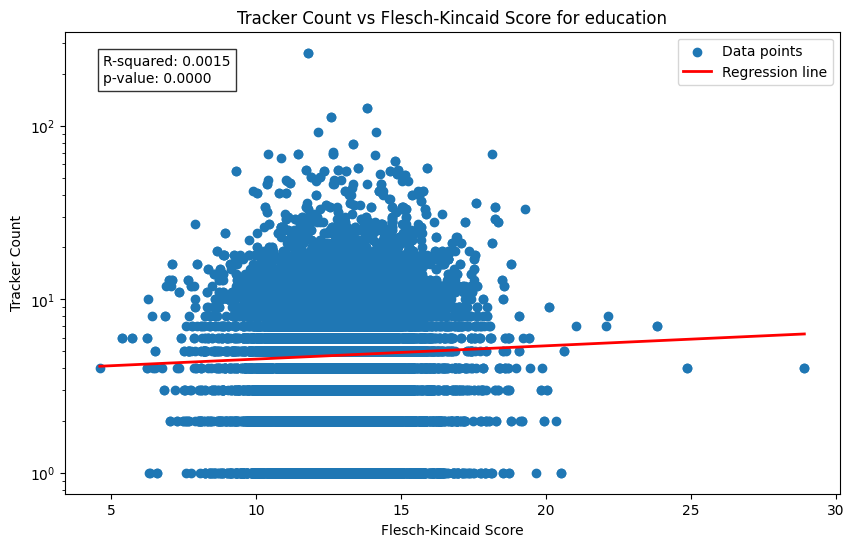


Regression Statistics for education:
Slope: 0.0077
Intercept: 0.5787
R-squared: 0.0015
p-value: 0.0000


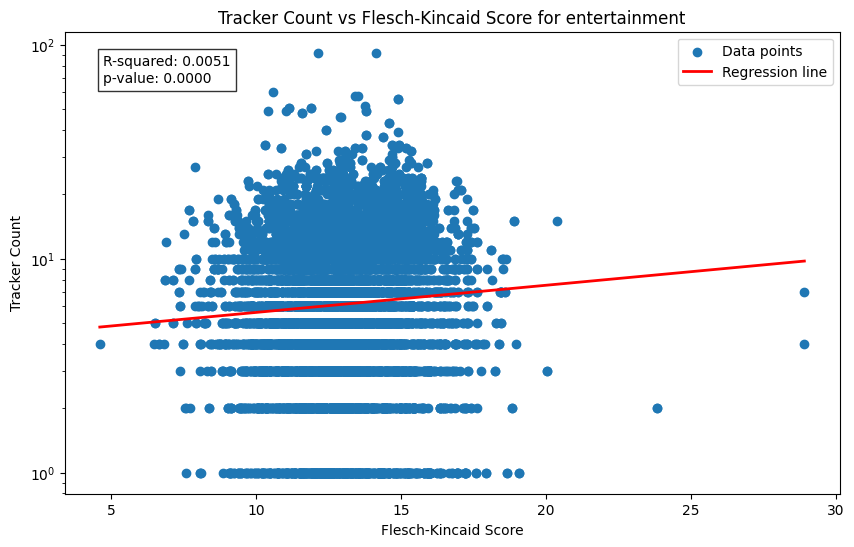


Regression Statistics for entertainment:
Slope: 0.0127
Intercept: 0.6227
R-squared: 0.0051
p-value: 0.0000


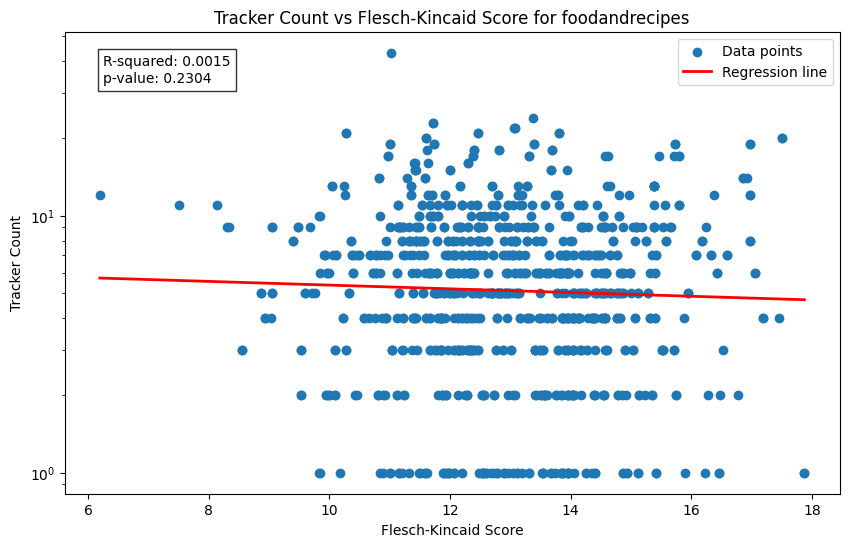


Regression Statistics for foodandrecipes:
Slope: -0.0072
Intercept: 0.8019
R-squared: 0.0015
p-value: 0.2304


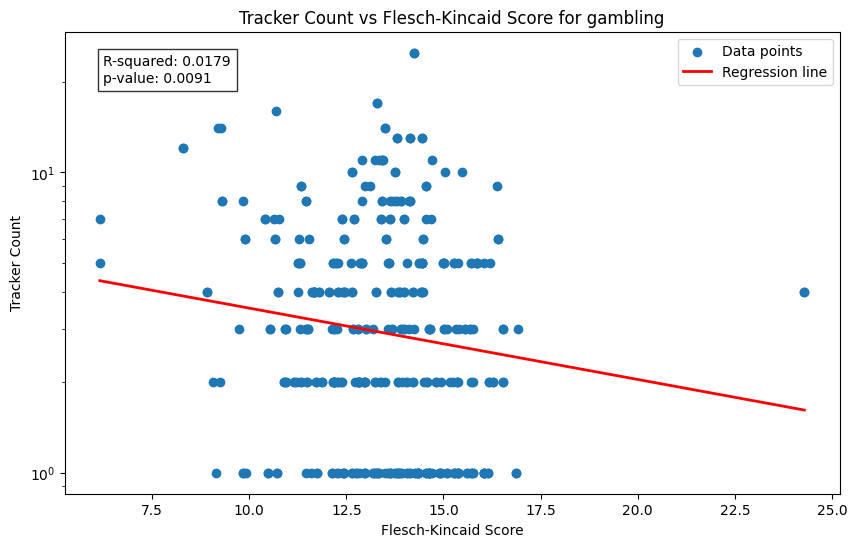


Regression Statistics for gambling:
Slope: -0.0238
Intercept: 0.7854
R-squared: 0.0179
p-value: 0.0091


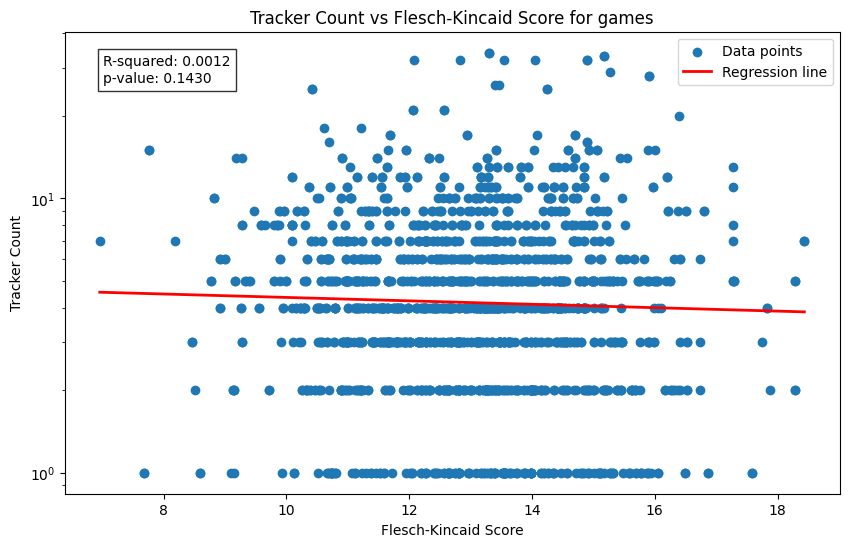


Regression Statistics for games:
Slope: -0.0062
Intercept: 0.7016
R-squared: 0.0012
p-value: 0.1430

Skipping hacking - insufficient data variation


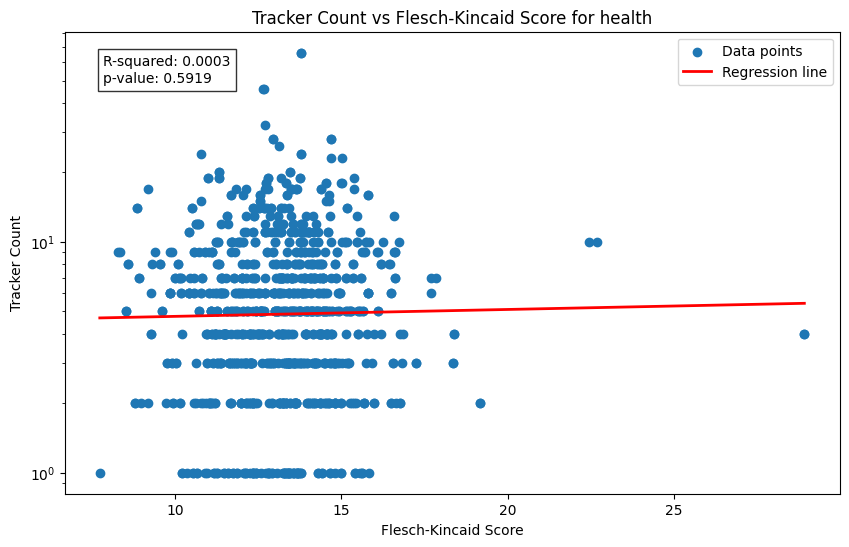


Regression Statistics for health:
Slope: 0.0030
Intercept: 0.6475
R-squared: 0.0003
p-value: 0.5919


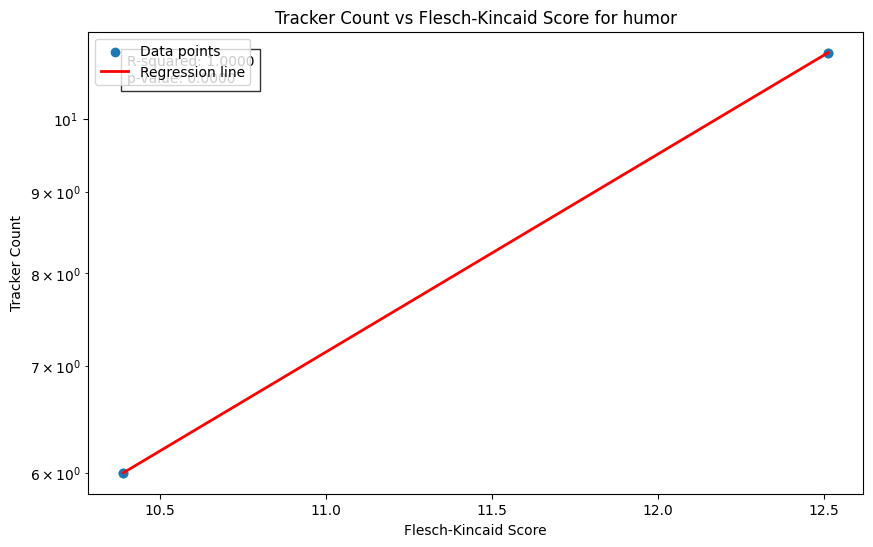


Regression Statistics for humor:
Slope: 0.1240
Intercept: -0.5098
R-squared: 1.0000
p-value: 0.0000


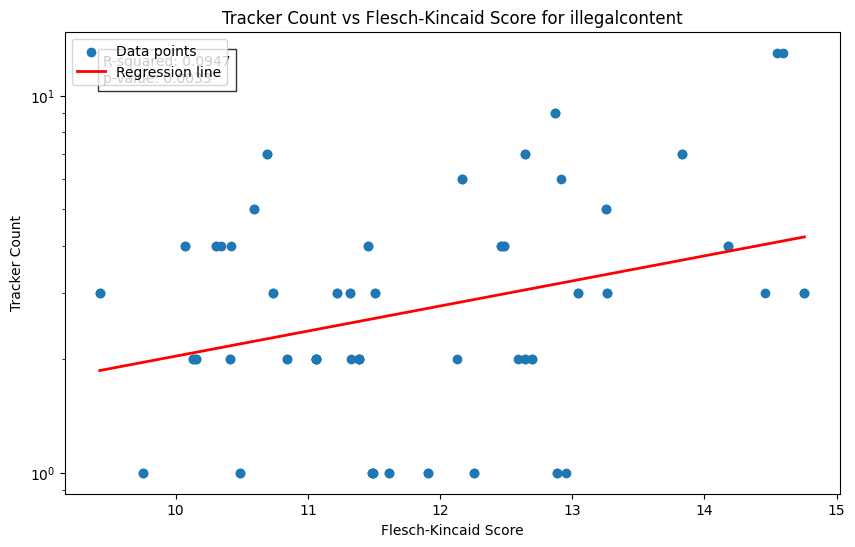


Regression Statistics for illegalcontent:
Slope: 0.0665
Intercept: -0.3557
R-squared: 0.0947
p-value: 0.0033


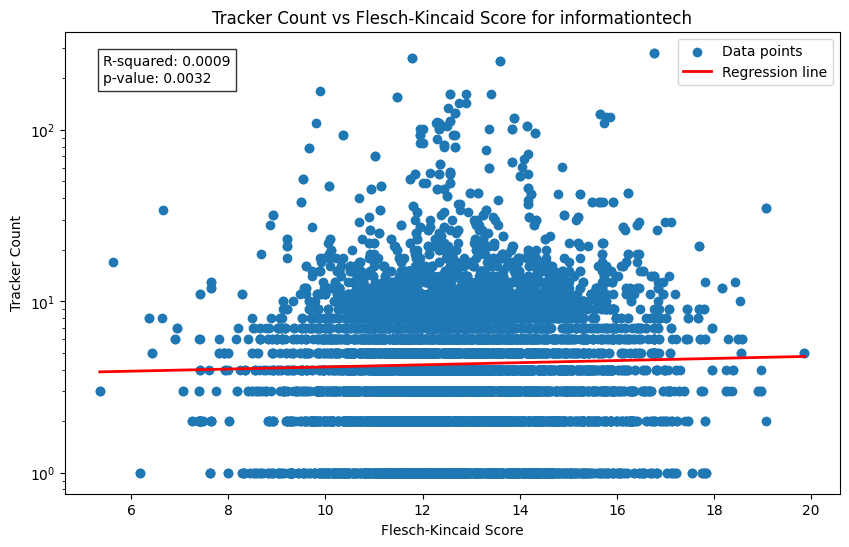


Regression Statistics for informationtech:
Slope: 0.0062
Intercept: 0.5553
R-squared: 0.0009
p-value: 0.0032


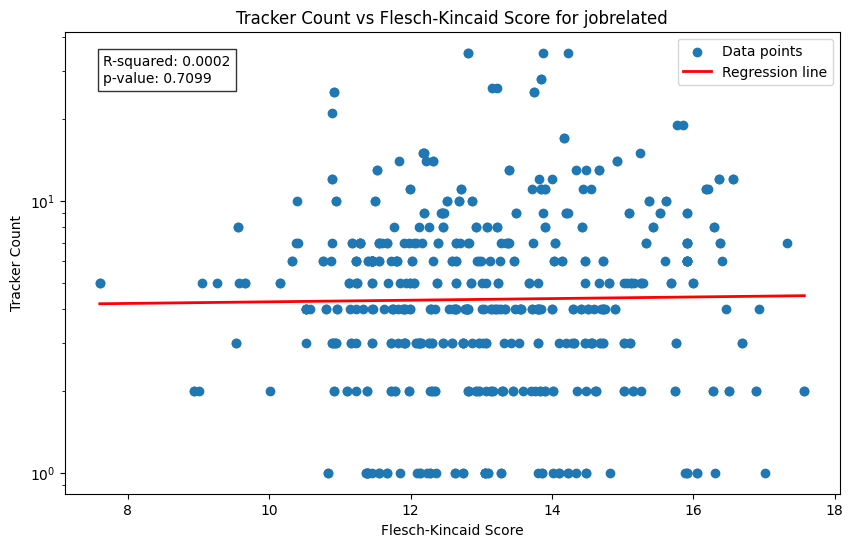


Regression Statistics for jobrelated:
Slope: 0.0030
Intercept: 0.5986
R-squared: 0.0002
p-value: 0.7099


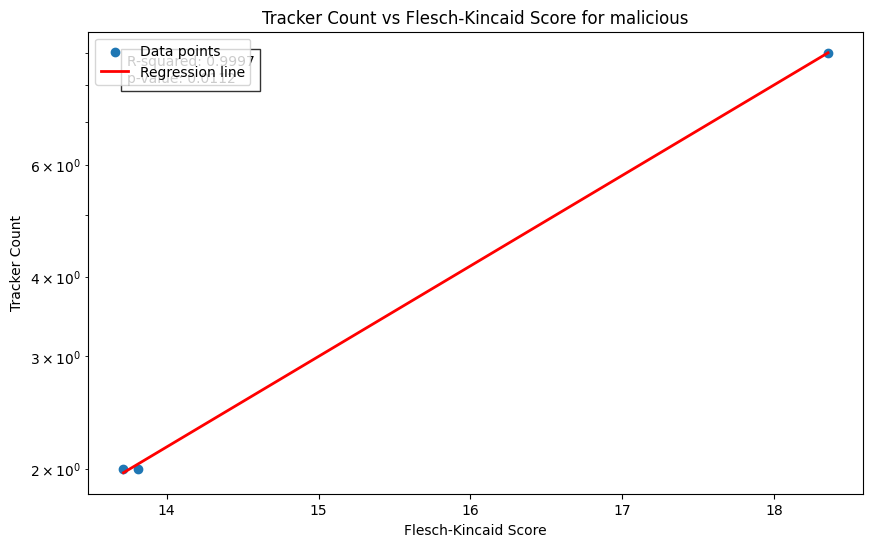


Regression Statistics for malicious:
Slope: 0.1422
Intercept: -1.6566
R-squared: 0.9997
p-value: 0.0112


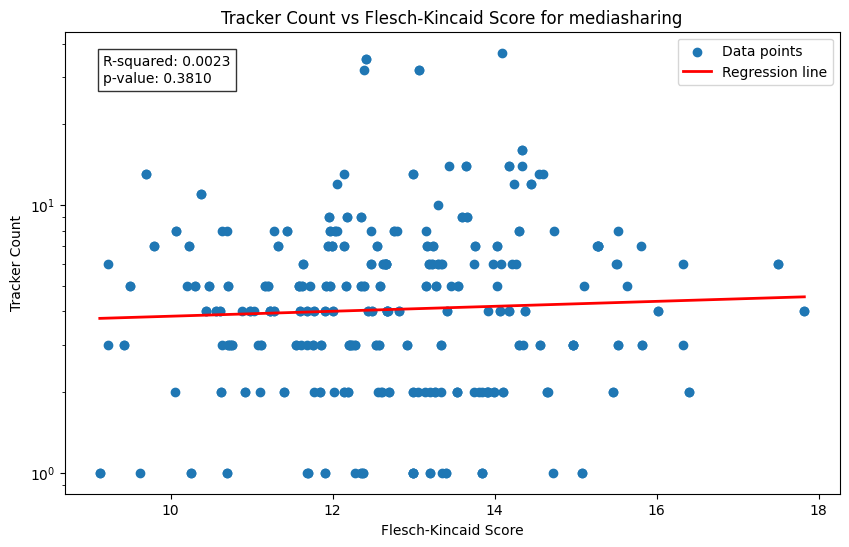


Regression Statistics for mediasharing:
Slope: 0.0092
Intercept: 0.4919
R-squared: 0.0023
p-value: 0.3810


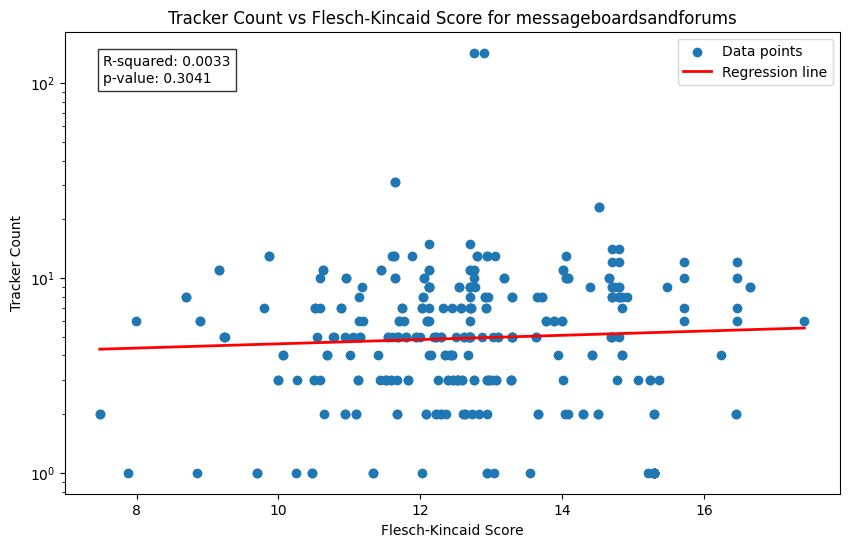


Regression Statistics for messageboardsandforums:
Slope: 0.0109
Intercept: 0.5522
R-squared: 0.0033
p-value: 0.3041


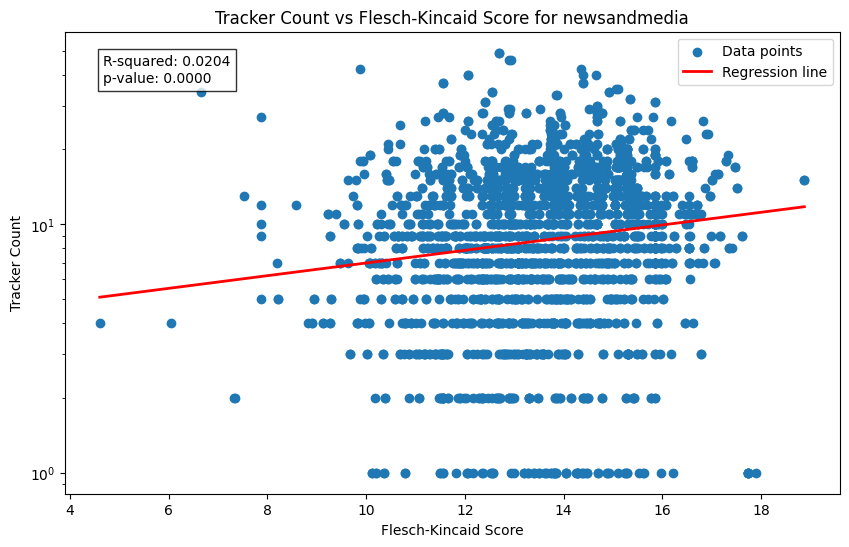


Regression Statistics for newsandmedia:
Slope: 0.0255
Intercept: 0.5890
R-squared: 0.0204
p-value: 0.0000


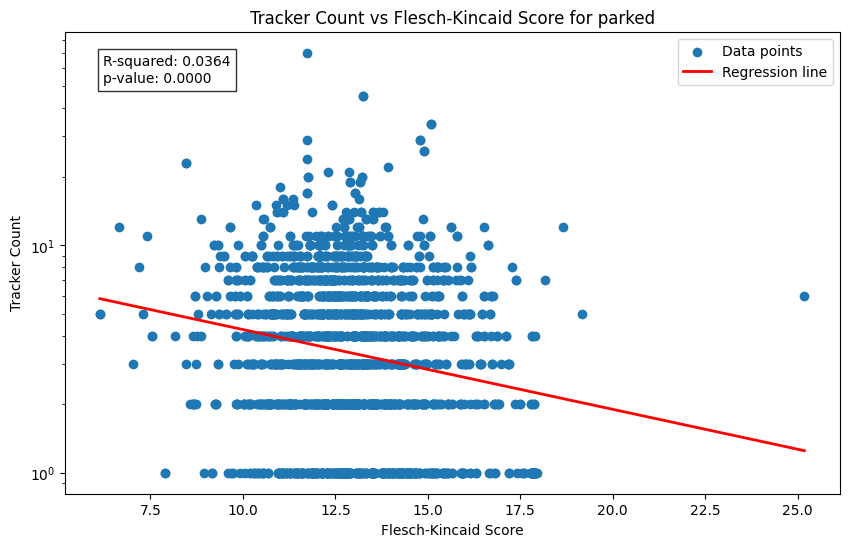


Regression Statistics for parked:
Slope: -0.0351
Intercept: 0.9795
R-squared: 0.0364
p-value: 0.0000


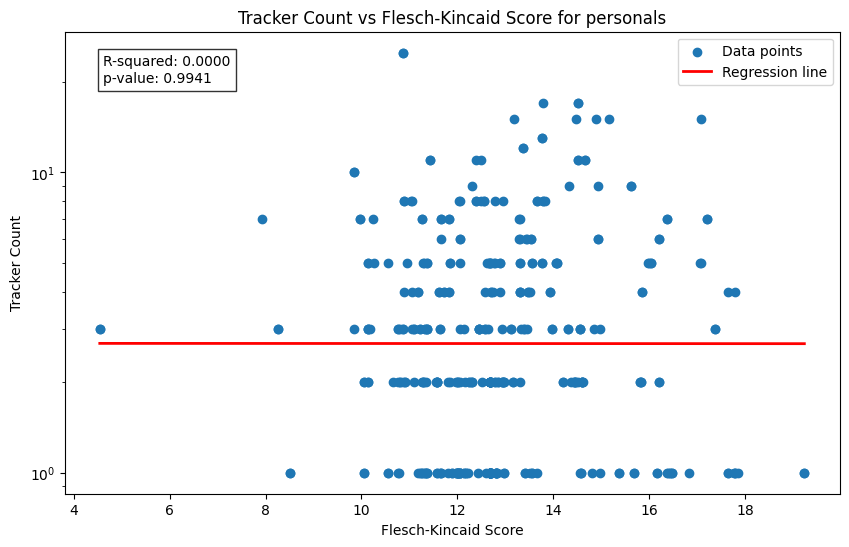


Regression Statistics for personals:
Slope: -0.0001
Intercept: 0.4308
R-squared: 0.0000
p-value: 0.9941


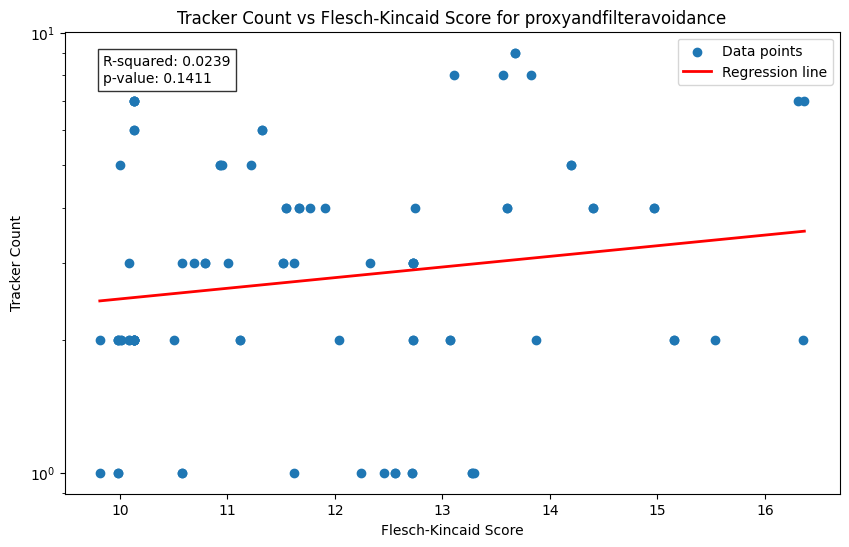


Regression Statistics for proxyandfilteravoidance:
Slope: 0.0242
Intercept: 0.1532
R-squared: 0.0239
p-value: 0.1411


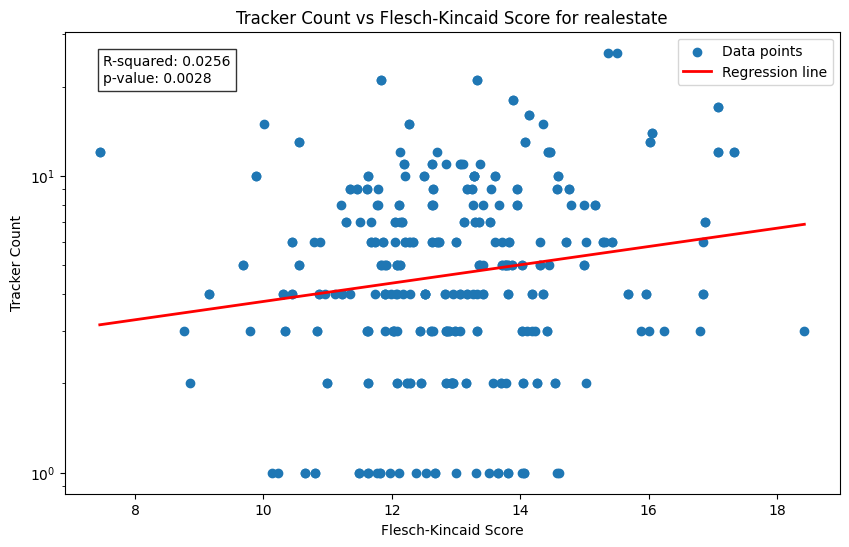


Regression Statistics for realestate:
Slope: 0.0309
Intercept: 0.2684
R-squared: 0.0256
p-value: 0.0028


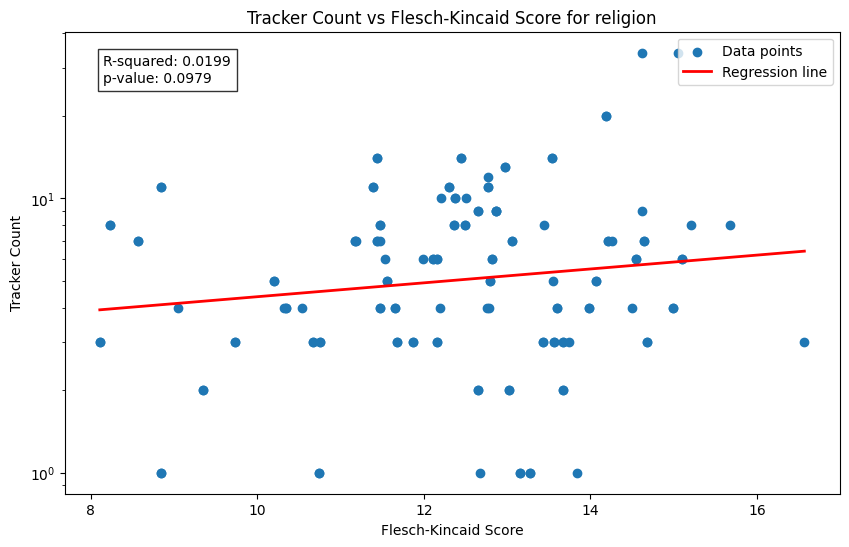


Regression Statistics for religion:
Slope: 0.0253
Intercept: 0.3890
R-squared: 0.0199
p-value: 0.0979


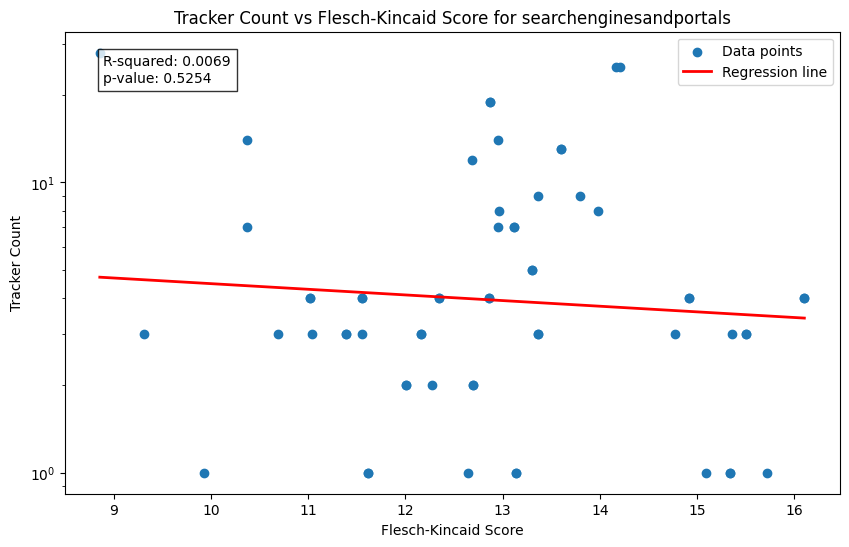


Regression Statistics for searchenginesandportals:
Slope: -0.0194
Intercept: 0.8457
R-squared: 0.0069
p-value: 0.5254


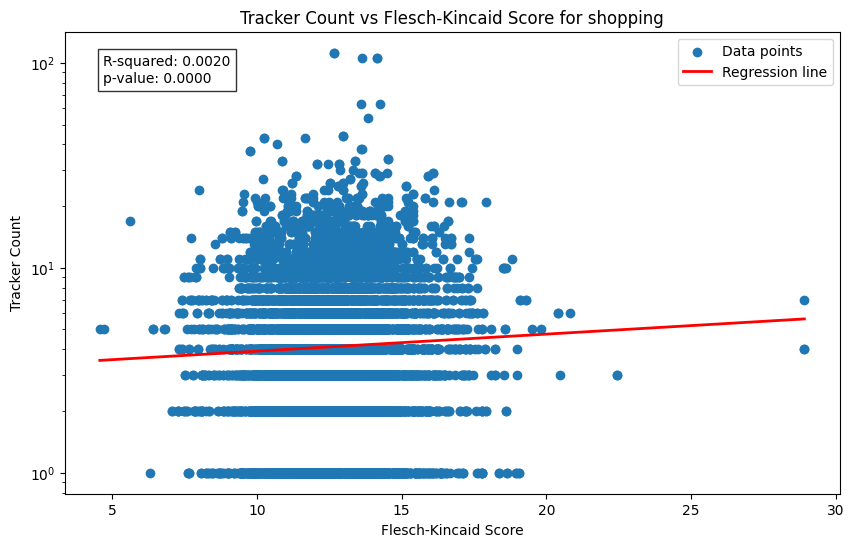


Regression Statistics for shopping:
Slope: 0.0083
Intercept: 0.5100
R-squared: 0.0020
p-value: 0.0000


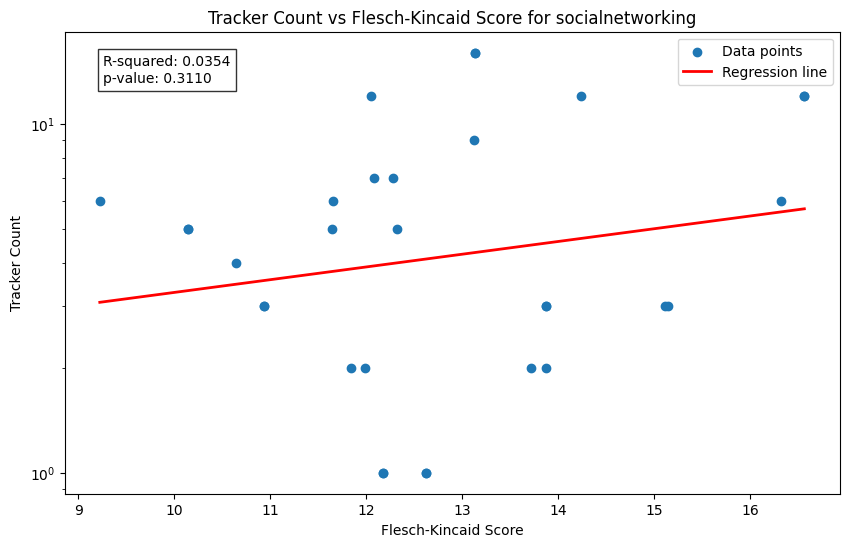


Regression Statistics for socialnetworking:
Slope: 0.0365
Intercept: 0.1517
R-squared: 0.0354
p-value: 0.3110


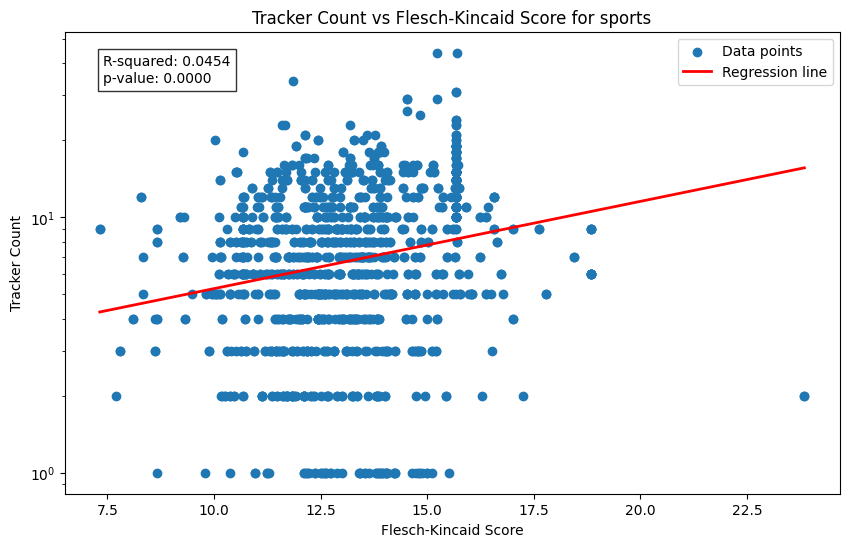


Regression Statistics for sports:
Slope: 0.0341
Intercept: 0.3789
R-squared: 0.0454
p-value: 0.0000


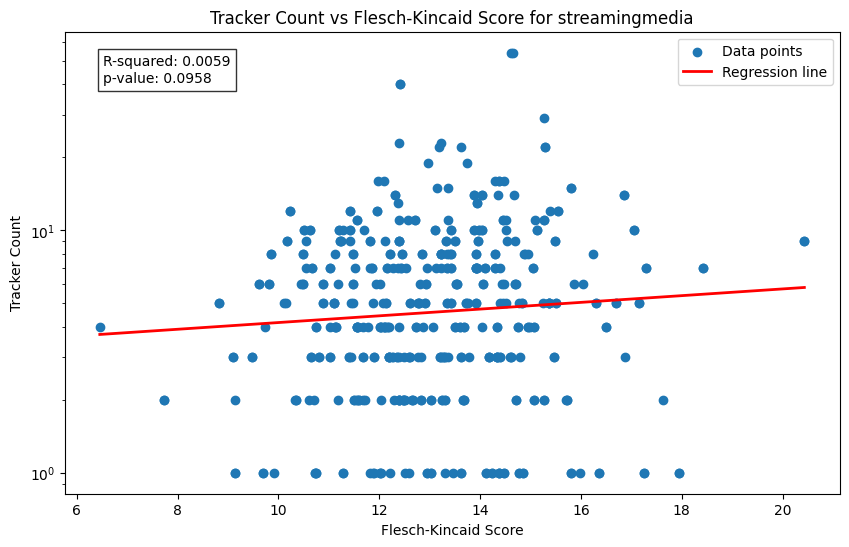


Regression Statistics for streamingmedia:
Slope: 0.0139
Intercept: 0.4808
R-squared: 0.0059
p-value: 0.0958


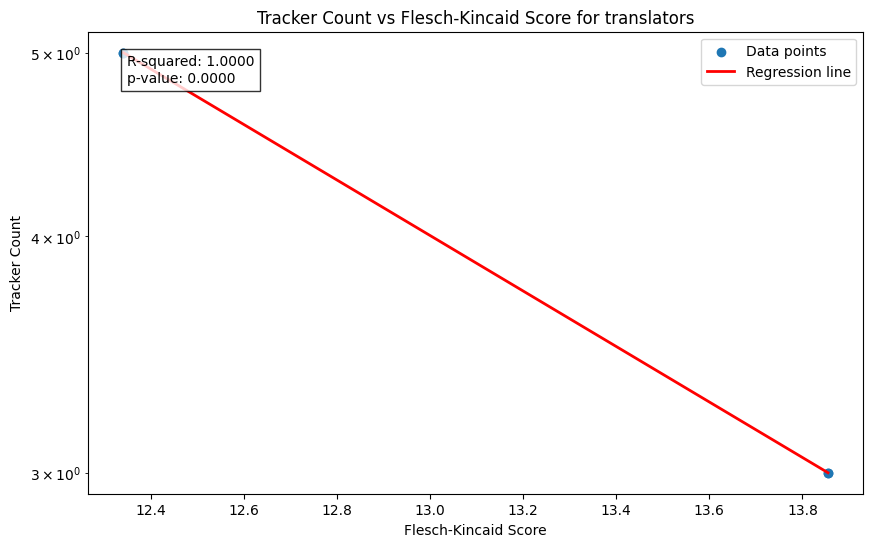


Regression Statistics for translators:
Slope: -0.1466
Intercept: 2.5077
R-squared: 1.0000
p-value: 0.0000


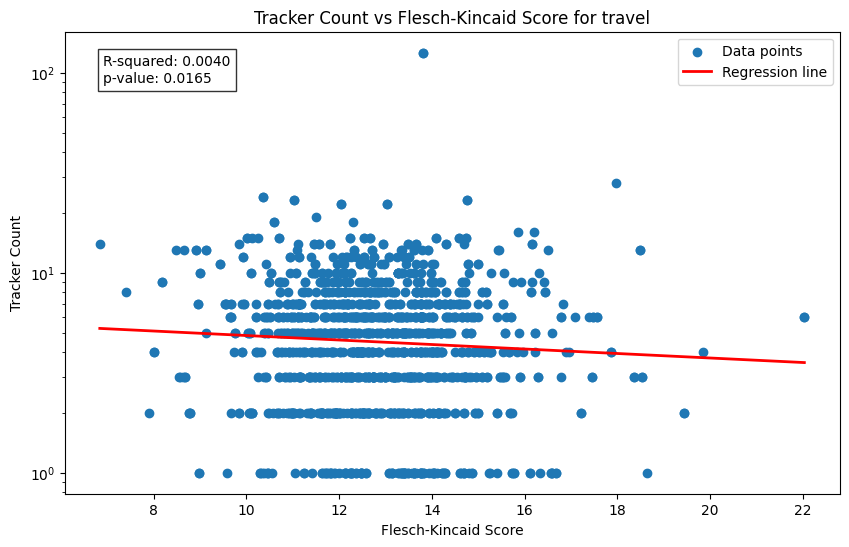


Regression Statistics for travel:
Slope: -0.0112
Intercept: 0.7986
R-squared: 0.0040
p-value: 0.0165


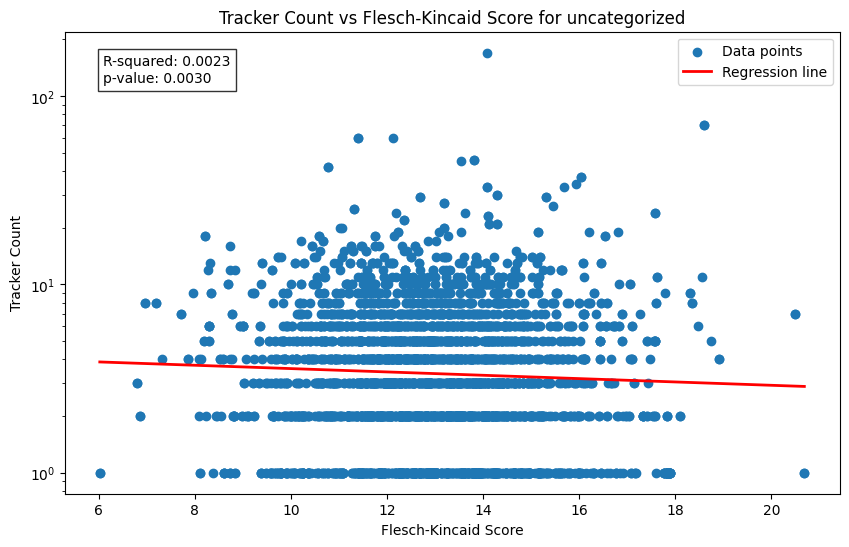


Regression Statistics for uncategorized:
Slope: -0.0089
Intercept: 0.6417
R-squared: 0.0023
p-value: 0.0030


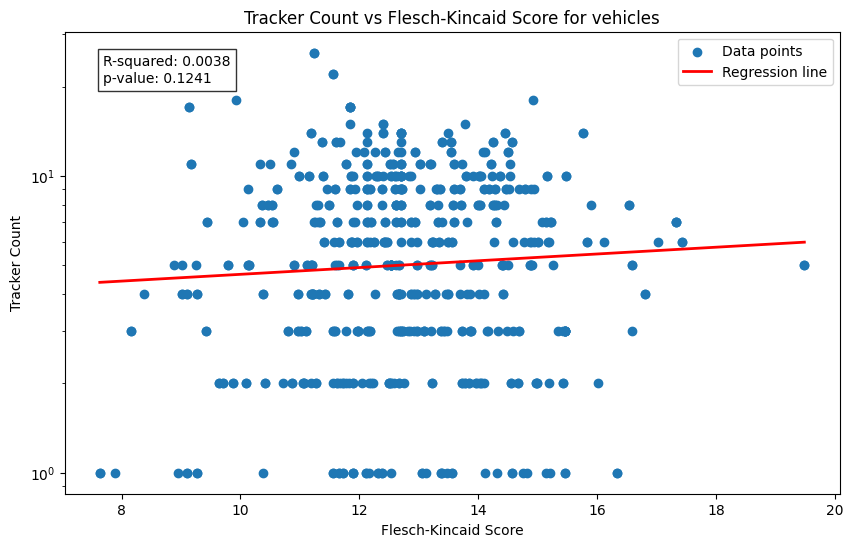


Regression Statistics for vehicles:
Slope: 0.0114
Intercept: 0.5542
R-squared: 0.0038
p-value: 0.1241

Skipping virtualreality - insufficient data variation


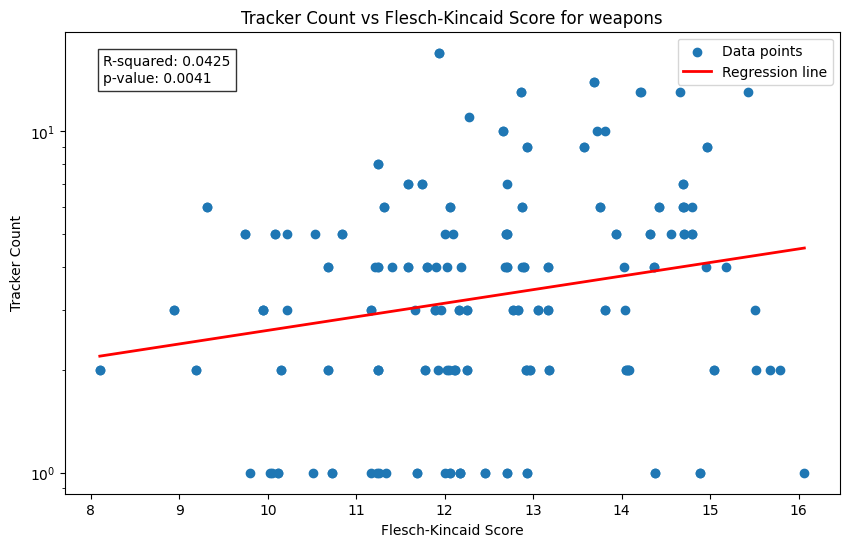


Regression Statistics for weapons:
Slope: 0.0398
Intercept: 0.0194
R-squared: 0.0425
p-value: 0.0041


In [ ]:
def plot_category_with_regression(df, category):
    category_data = df[df[category] == 1]
    x = category_data['flesch_kincaid']
    
    # Check if there's enough variation in x values
    if len(x) <= 1 or x.nunique() == 1:
        print(f"\nSkipping {category} - insufficient data variation")
        return
        
    y = np.log10(category_data['tracker_count'])
    
    # Perform regression on log-transformed data
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    # Create prediction line
    x_sorted = np.sort(x)
    y_pred = slope * x_sorted + intercept
    
    plt.figure(figsize=(10, 6))
    plt.scatter(x, category_data['tracker_count'], label='Data points')
    plt.plot(x_sorted, 10**y_pred, color='red', label='Regression line', linewidth=2)
    
    plt.text(0.05, 0.95, 
             f'R-squared: {r_value**2:.4f}\np-value: {p_value:.4f}',
             transform=plt.gca().transAxes,
             verticalalignment='top',
             bbox=dict(facecolor='white', alpha=0.8))
    
    plt.title(f'Tracker Count vs Flesch-Kincaid Score for {category}')
    plt.xlabel('Flesch-Kincaid Score')
    plt.ylabel('Tracker Count')
    plt.yscale('log')
    plt.legend()
    plt.show()
    
    print(f"\nRegression Statistics for {category}:")
    print(f"Slope: {slope:.4f}")
    print(f"Intercept: {intercept:.4f}")
    print(f"R-squared: {r_value**2:.4f}")
    print(f"p-value: {p_value:.4f}")

# Run the analysis for each category
for category in categories.columns:
    plot_category_with_regression(df_expanded, category)
